# FIRST ALGORITHMS 

In this notebook, we start with the first algorithm, true,fake,antifake

In [1]:
import pandas as pd
import numpy as np

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from matplotlib import pyplot

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.linear_model import LogisticRegression


from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score   
from sklearn.model_selection import KFold
import sklearn
sklearn.__version__
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

/home/david/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data preprocessing

In [2]:
df= pd.read_csv(r'/home/david/Escritorio/VACCINATION_PROJECT/no_vax_sentiment.csv')

### Clean data and lower case 

In [3]:
def preprocessor(text):
#     
    text = re.sub('[^a-zA-Z]', ' ',text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    
df['Text_en'] = df['Text_en'].apply(preprocessor)

### Remove stop words 

In [4]:
stop = [word.lower() for word in stopwords.words('english')]
newStopWords = ['n','xa','and', 'this', 'that', 'on','but','the','might','per','according', 'across','as','although']
stop.extend([word.lower() for word in newStopWords])
df['Text_en_no_stopwords'] = df['Text_en'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stop)]))


In [16]:
y = df.Country
X = df.Text_en_no_stopwords

# Implementing Classification Algorithm

First we start with an algorithm of the Majority CLass Baseline type. For Classification: If you have a classification problem, you can select the class that has the most observations and use that class as the result for all predictions. 

### Majority Class Baseline 

In [17]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X,y)
dummy_clf.predict(X) 
dummy_clf.score(X,y)

0.29283314669652855

### SPLIT DATA

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df['Text_en_no_stopwords'], y, test_size=0.2,random_state=102)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1428,) (1428,)
(358,) (358,)


### Logistic Regression

With logistic regression, the coefficients (coef_ attribute) of the model can be used to infer feature importance. The magnitude and sign of the coefficients indicate the strength and direction of the relationship between each feature and the target variable. A positive coefficient indicates that an increase in the feature results in an increase in the probability of the target variable being positive, while a negative coefficient indicates the opposite.

However, this interpretation is only valid when the features are independent and the dataset is linearly separable. In other cases, this interpretation may not be accurate and other feature importance techniques should be used.

In a multiclass classification problem, logistic regression creates one binary classifier for each class, and each classifier has its own set of coefficients. So for each binary classifier, the coefficients of the features can be used to infer the feature importance for each class.

Also, logistic regression is a linear model and the relationship between the features and the target variable is assumed to be linear. If the relationship is non-linear, logistic regression may not be able to capture it and other models such as Random Forest would be more appropriate.

accuracy: 81.84%


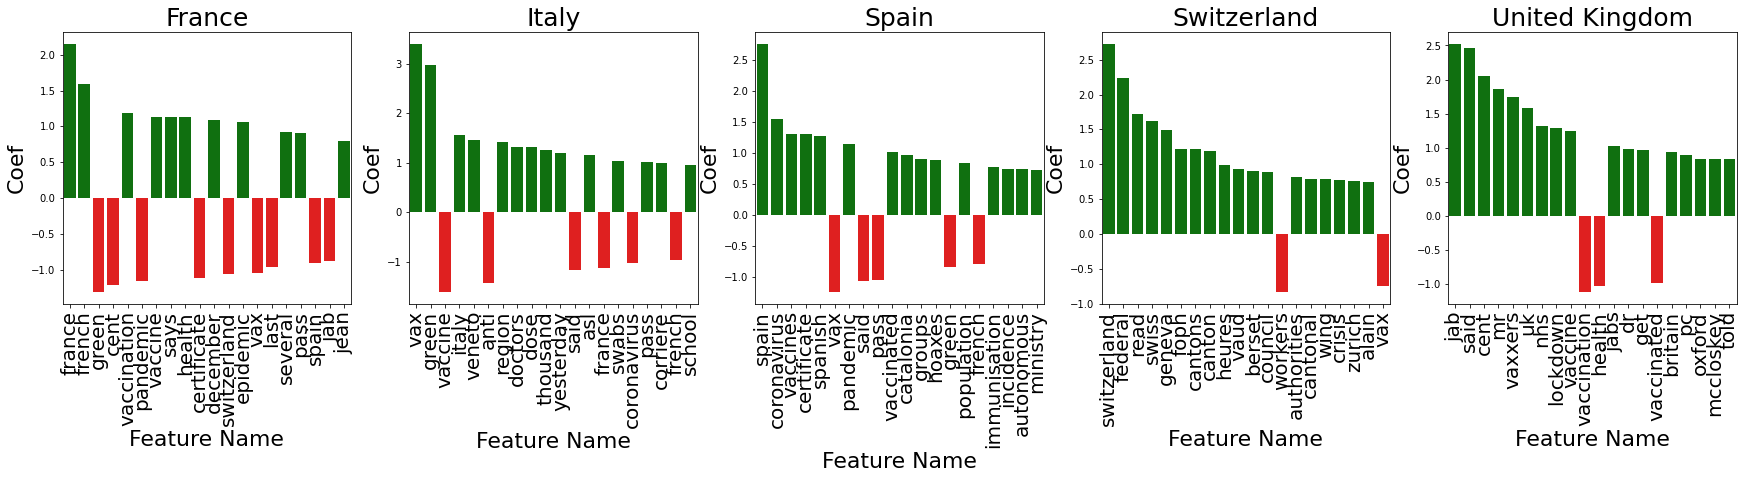

In [28]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
# Fitting the model
model = pipe.fit(X_train, y_train)
# Accuracy
prediction = model.predict(X_test)
accuracy_log = accuracy_score(y_test, prediction)*100
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

feature_names = pipe.named_steps['vect'].get_feature_names()

country_list = ["France", "Italy", "Spain", "Switzerland", "United Kingdom"]
fig, axs = plt.subplots(1, 5, figsize=(30, 5))
for i in range(5):
    coefs = pipe.named_steps["model"].coef_[i]

    # Zip coefficients and names together and make a DataFrame
    zipped = zip(feature_names, coefs)
    df_features = pd.DataFrame(zipped, columns=["feature", "value"])
    # Sort the features by the absolute value of their coefficient
    df_features["abs_value"] = df_features["value"].apply(lambda x: abs(x))
    df_features["colors"] = df_features["value"].apply(lambda x: "green" if x > 0 else "red")
    df_features = df_features.sort_values("abs_value", ascending=False)
    
    sns.barplot(x="feature",
                y="value",
                data=df_features.head(20),
                palette=df_features.head(20)["colors"],
                ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90, fontsize=20)
    axs[i].set_title(country_list[i], fontsize=25)
    axs[i].set_ylabel("Coef", fontsize=22)
    axs[i].set_xlabel("Feature Name", fontsize=22)


Negative odd ratio e.g -n shows the predictor variable is n times less likely to cause change in the dependent variable than the reference category. Or an increase in non-categorical variable is less likely to cause change in the dependent variable

## Using Cross Validation

Why stratified?-->The splitting of data into folds may be governed by criteria such as ensuring that each fold has the same proportion of observations with a given categorical value, such as the class outcome value. This is called stratified cross-validation.

In [10]:
# clf[SVC(kernel='linear'),LogisticRegression(),RandomForestClassifier(),DecisionTreeClassifier()]
def model(n_splits, X, y, clf): 
    score_array=[]
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X, y):
#         print(train_index.shape)
#         print(test_index.shape)
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
#         I put lowercase false to use the lematization, i put the words in lowercase in a step before
        tfidf = TfidfVectorizer(lowercase=False)
        x_train = tfidf.fit_transform(x_train)
        x_test = tfidf.transform(x_test)
#         print(x_train)

        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        score = accuracy_score(y_test, y_pred)
#         print(score)
        score_array.append(accuracy_score(y_test, y_pred)) 
    avg_score = np.mean(score_array,axis=0)
    print(f"The average of the accuracy {n_splits}-folds is {avg_score}")
    return avg_score
    

Cleaning Data using NLP Techniques
The data we currently possess in X_train and X_test still needs to be converted into a format that can be interpreted by a machine learning algorithm, since these algorithms do not work well with textual data. Hence, we need to convert it into a form that will enable the algorithm to discern patterns and meaningful insights from the data. In order to achieve this, I implemented Tf-Idf.

### Logistic regression

In [11]:
lr=model(5, X, y, LogisticRegression())

The average of the accuracy 5-folds is 0.8225059856344773
